In [1]:
import os
import numpy as np
import pandas as pd
from jiwer import wer
import tensorflow as tf
from IPython import display
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["ID", "Transcription", "Normalized Transcription"]
metadata_df = metadata_df[["ID", "Normalized Transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(5)

,ID,Normalized Transcription
0,LJ045-0239,"which has been set forth above, only served to..."
1,LJ042-0234,"quote, except in the US, the living standard i..."
2,LJ011-0083,For a long time justice did not overtake him f...
3,LJ034-0210,The picture which gave rise to these allegatio...
4,LJ001-0030,a very few years saw the birth of Roman charac...


In [3]:
split = int(len(metadata_df) * 0.90)
train_data = metadata_df[:split]
validation_data = metadata_df[split:]   

print(f"Size of the training set: {len(train_data)}")
print(f"Size of the training set: {len(validation_data)}")

Size of the training set: 11790
Size of the training set: 1310


In [4]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_int = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
int_to_char = keras.layers.StringLookup(vocabulary=char_to_int.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_int.get_vocabulary()} " f"(size = {char_to_int.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size = 31)


In [5]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_int(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [6]:
batch_size = 8
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_data["ID"]), list(train_data["Normalized Transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(validation_data["ID"]), list(validation_data["Normalized Transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

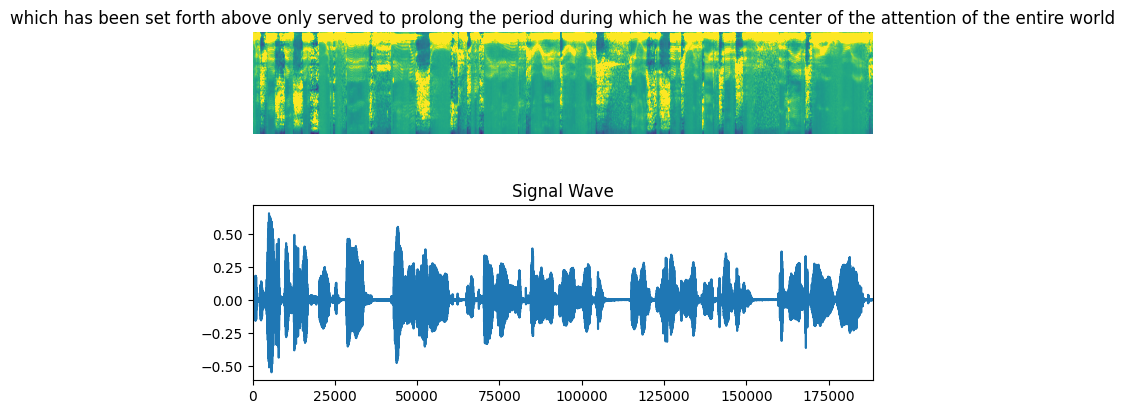

In [7]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(int_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(train_data["ID"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [8]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [9]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    
    # Model's input
    input_spectrogram = tf.keras.layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = tf.keras.layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding="same", use_bias=False, name="conv_1")(x)
    x = tf.keras.layers.BatchNormalization(name="conv_1_bn")(x)
    x = tf.keras.layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding="same", use_bias=False, name="conv_2")(x)
    x = tf.keras.layers.BatchNormalization(name="conv_2_bn")(x)
    x = tf.keras.layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = tf.keras.layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # LSTM layers
    for i in range(1, rnn_layers + 1):
        recurrent = tf.keras.layers.LSTM(units=rnn_units, activation="tanh", recurrent_activation="sigmoid", use_bias=True, return_sequences=True, name=f"lstm_{i}")
        x = tf.keras.layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i < rnn_layers:
            x = tf.keras.layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = tf.keras.layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = tf.keras.layers.ReLU(name="dense_1_relu")(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = tf.keras.layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output)
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [10]:
# Get the model
model = build_model(input_dim=fft_length // 2 + 1,output_dim=char_to_int.vocabulary_size(),rnn_units=512,)
model.summary(line_length=110)

Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                        128 

In [11]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(int_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [12]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(int_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [13]:
# Define the number of epochs.
epochs = 100

# Directories for saving checkpoints and the final model
checkpoint_dir = 'checkpoint'
final_model_dir = 'models'
graph_dir = 'graphs'

# Ensure directories exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)
os.makedirs(graph_dir, exist_ok=True)

# ModelCheckpoint callback to save the model checkpoint after each epoch
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_dir, 'model_epoch_{epoch:03d}.ckpt'),  # Name of the checkpoint files
    save_weights_only=True,  # If you only want to save weights, not full model
    save_freq='epoch',  # Save after each epoch
    verbose=1  # Log a message each time a model is saved
)

# EarlyStopping callback to stop training when the validation loss stops improving
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Log a message when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
    
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, model_checkpoint_callback, early_stopping_callback],  # Include early stopping callback here
)

# Save the final model in .keras format
final_model_path = os.path.join(final_model_dir, 'model_mark_1.keras')
model.save(final_model_path)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the loss graph
graph_path = os.path.join(graph_dir, 'loss_graph.png')
plt.savefig(graph_path)
plt.close()

Epoch 1/100


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[model/bidirectional_1/forward_lstm_1/PartitionedCall]]
	 [[CTCLoss/scan/while/exit/_32/_50]]
  (1) INVALID_ARGUMENT:  No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[model/bidirectional_1/forward_lstm_1/PartitionedCall]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_27283]